## Projeto final do módulo de Machine Learning 1
### Análise exploratória e modelos de previsão de salários de profissionais de ciências de dados
### Por: Tiago Guedes
O seguinte trabalho propõe uma análise exploratória e treino de um modelo de machine learning capaz de estimar o salário de um profissional na área com base nas informações providas.

Dataset utilizado: https://www.kaggle.com/datasets/arnabchaki/data-science-salaries-2023/code

Dicionario do dataset:
- work_year: The year the salary was paid.
- experience_level: The experience level in the job during the year
- employment_type: The type of employment for the role
- job_title: The role worked in during the year.
- salary: The total gross salary amount paid.
- salary_currency: The currency of the salary paid as an ISO 4217 currency code.
- salaryinusd: The salary in USD
- employee_residence: Employee's primary country of residence in during the work year as an ISO 3166 country code.
- remote_ratio: The overall amount of work done remotely
- company_location: The country of the employer's main office or contracting branch
- company_size: The median number of people that worked for the company during the year

In [47]:
#imports necessários
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

In [2]:
salarios = pd.read_csv('ds_salaries.csv')

In [3]:
salarios.head(3)

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2023,SE,FT,Principal Data Scientist,80000,EUR,85847,ES,100,ES,L
1,2023,MI,CT,ML Engineer,30000,USD,30000,US,100,US,S
2,2023,MI,CT,ML Engineer,25500,USD,25500,US,100,US,S


In [4]:
salarios.isna().sum()

work_year             0
experience_level      0
employment_type       0
job_title             0
salary                0
salary_currency       0
salary_in_usd         0
employee_residence    0
remote_ratio          0
company_location      0
company_size          0
dtype: int64

In [5]:
salarios.describe()

,work_year,salary,salary_in_usd,remote_ratio
count,3755.000000,3.755000e+03,3755.000000,3755.000000
mean,2022.373635,1.906956e+05,137570.389880,46.271638
std,0.691448,6.716765e+05,63055.625278,48.589050
min,2020.000000,6.000000e+03,5132.000000,0.000000
25%,2022.000000,1.000000e+05,95000.000000,0.000000
50%,2022.000000,1.380000e+05,135000.000000,0.000000
75%,2023.000000,1.800000e+05,175000.000000,100.000000
max,2023.000000,3.040000e+07,450000.000000,100.000000


In [6]:
salarios.info()
salarios.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3755 entries, 0 to 3754
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   work_year           3755 non-null   int64 
 1   experience_level    3755 non-null   object
 2   employment_type     3755 non-null   object
 3   job_title           3755 non-null   object
 4   salary              3755 non-null   int64 
 5   salary_currency     3755 non-null   object
 6   salary_in_usd       3755 non-null   int64 
 7   employee_residence  3755 non-null   object
 8   remote_ratio        3755 non-null   int64 
 9   company_location    3755 non-null   object
 10  company_size        3755 non-null   object
dtypes: int64(4), object(7)
memory usage: 322.8+ KB


(3755, 11)

Descartamos as colunas salary e salary_currency, visto que somente usaremos a coluna salary_in_usd afim de evitar data leakage

In [7]:
salarios = salarios.drop(['salary','salary_currency','company_location', 'employee_residence'], axis=1)
salarios.shape

(3755, 7)

## Vamos checar como se distribuem algumas de nossas informações categóricas:

### Tipo de contrato:

In [8]:
salarios['employment_type'].value_counts(normalize='True')
#Vemos que mais de 99% da base é composta de contratos "Full time"

FT    0.990146
PT    0.004527
CT    0.002663
FL    0.002663
Name: employment_type, dtype: float64

### Cargos

In [9]:
#Quantos cargos existem na base e como estão distribuidos
numero_de_cargos = len(salarios['job_title'].unique())
print(f'Existem {numero_de_cargos} cargos distintos nomeados na base.')
salarios['job_title'].value_counts()

Existem 93 cargos distintos nomeados na base.


Data Engineer                          1040
Data Scientist                          840
Data Analyst                            612
Machine Learning Engineer               289
Analytics Engineer                      103
                                       ... 
Principal Machine Learning Engineer       1
Azure Data Engineer                       1
Manager Data Management                   1
Marketing Data Engineer                   1
Finance Data Analyst                      1
Name: job_title, Length: 93, dtype: int64

Como existem muitos cargos distintos, e isso tornará o trabalho de encoding dessa variável muito árduo iremos descartar os cargos que contem poucos valores, o critério usado é que serão descartados os cargos menos populados até que ainda conservemos pelo menos 90% das linhas da base:

In [10]:
i=0
while salarios['job_title'].value_counts().nlargest(i).sum()/salarios.shape[0]<0.9:
    i+=1
print(f'Usaremos somente os {i} cargos mais populados na base:')
cargos_usados = salarios['job_title'].value_counts().nlargest(i).index.tolist()
for cargo in cargos_usados:
    print(cargo)

Usaremos somente os 17 cargos mais populados na base:
Data Engineer
Data Scientist
Data Analyst
Machine Learning Engineer
Analytics Engineer
Data Architect
Research Scientist
Data Science Manager
Applied Scientist
Research Engineer
ML Engineer
Data Manager
Machine Learning Scientist
Data Science Consultant
Data Analytics Manager
Computer Vision Engineer
AI Scientist


In [11]:
salarios_filtrado = salarios[salarios['job_title'].isin(cargos_usados)].copy()
print(f'Foram conservadas {round(salarios_filtrado.shape[0]/salarios.shape[0]*100,2)}% das linhas da base original')
numero_cargos_filtrados = len(salarios_filtrado['job_title'].unique())
print(f'Existem agora {numero_cargos_filtrados} cargos distintos na base.')

Foram conservadas 90.25% das linhas da base original
Existem agora 17 cargos distintos na base.


### Nível de experiência

In [12]:
salarios_filtrado['experience_level'].value_counts(normalize='True')

SE    0.692240
MI    0.205370
EN    0.076424
EX    0.025966
Name: experience_level, dtype: float64

Lembrando que:
- SE : Senior
- EN : Entry level
- EX : Executive level
- MI : Mid/Intermediate level

## Vamos conferir como a média salarial se distribui ao longo de algumas dessas categorias
### Nível de experiência

In [13]:
salarios_filtrado.groupby('experience_level')['salary_in_usd'].describe()

,count,mean,std,min,25%,50%,75%,max
experience_level,,,,,,,,
EN,259.0,81834.671815,50559.195475,5707.0,47000.00,75000.0,120000.0,250000.0
EX,88.0,192623.738636,62689.588100,69741.0,145000.00,198100.0,236750.0,324000.0
MI,696.0,107118.127874,53327.343821,5679.0,70104.25,100000.0,140000.0,450000.0
SE,2346.0,154025.265558,55668.766957,15806.0,119000.00,147900.0,185900.0,423834.0


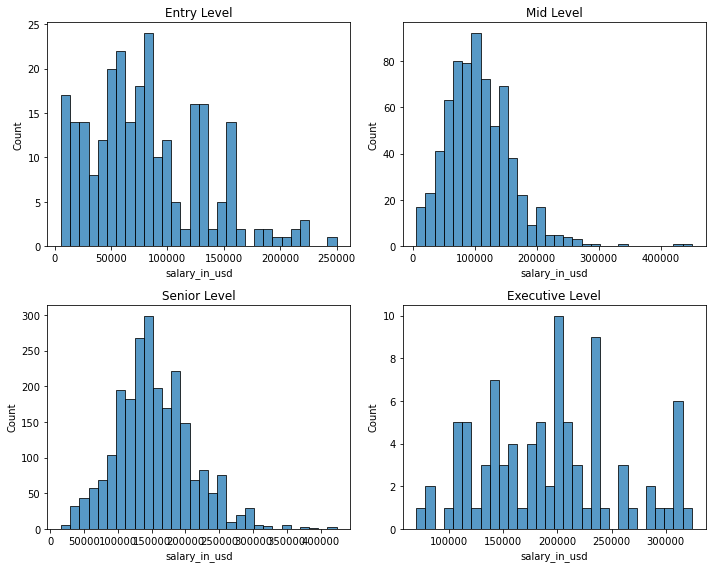

In [14]:
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

sns.histplot(ax=axes[0, 0], data=salarios_filtrado[salarios_filtrado['experience_level']=='EN'], x="salary_in_usd", bins=30)
sns.histplot(ax=axes[0, 1], data=salarios_filtrado[salarios_filtrado['experience_level']=='MI'], x="salary_in_usd", bins=30)
sns.histplot(ax=axes[1, 0], data=salarios_filtrado[salarios_filtrado['experience_level']=='SE'], x="salary_in_usd", bins=30)
sns.histplot(ax=axes[1, 1], data=salarios_filtrado[salarios_filtrado['experience_level']=='EX'], x="salary_in_usd", bins=30)

axes[0, 0].set_title("Entry Level")
axes[0, 1].set_title("Mid Level")
axes[1, 0].set_title("Senior Level")
axes[1, 1].set_title("Executive Level")

plt.tight_layout()

plt.show()

### Cargo

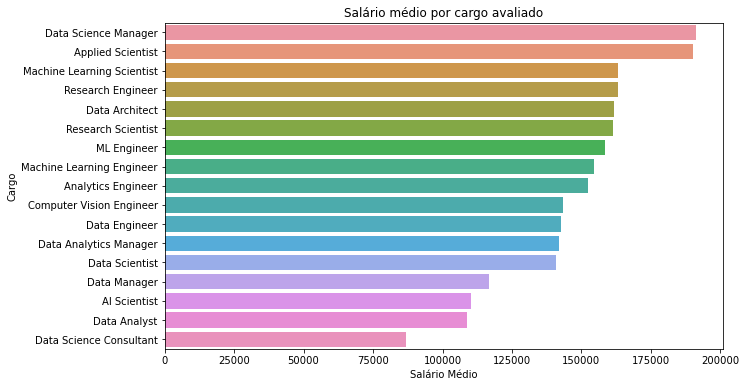

In [15]:
salarios_medios = salarios_filtrado.groupby('job_title')['salary_in_usd'].mean().sort_values(ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(y=salarios_medios.index, x=salarios_medios.values)

plt.xlabel('Salário Médio')
plt.ylabel('Cargo')
plt.title('Salário médio por cargo avaliado')

plt.show()

### Preparando para treino e teste de modelo
Precisamos definir quem serão nossos features e target.
O nosso target será o salário em dólares, para tal iremos nos livrar das colunas salary e salary_currency, conservando apenas a informação do salário em dólares, para evitar data leakage.

In [16]:
X = salarios_filtrado.drop('salary_in_usd', axis=1)
y = salarios_filtrado['salary_in_usd']
X.columns

Index(['work_year', 'experience_level', 'employment_type', 'job_title',
       'remote_ratio', 'company_size'],
      dtype='object')

Temos diversas colunas categoricas, como o cargo e o nível de experiência, precisamos decidir o tipo de encoding a ser usado em cada coluna:

In [48]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Colunas categoricas
Ordinal_cols = ['experience_level','employment_type']
OH_cols = ['job_title']

categoricas_preprocessor = ColumnTransformer(
    transformers=[
        ('ordinal', OrdinalEncoder(), Ordinal_cols), 
        ('onehot', OneHotEncoder(), OH_cols)
    ])

# Pipeline
pipeline = Pipeline([
    ('preprocessor', categoricas_preprocessor),
    ('regressor', LinearRegression()) 
])

# Fit
pipeline.fit(X_train, y_train)

# Predições
y_pred = pipeline.predict(X_test)

# Avaliação do modelo
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test,y_pred)
r2 = r2_score(y_test,y_pred)
print('Para o modelo de regressão linear:')
print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")
print(f"R2 Score: {r2}")

Para o modelo de regressão linear:
Mean Squared Error: 3154054822.1314044
Mean Absolute Error: 43064.59124701042
R2 Score: 0.22261119866219714


Testando o mesmo procedimento com regularizações Lasso e Ridge:

In [49]:
# Pipeline
pipeline_Lasso = Pipeline([
    ('preprocessor', categoricas_preprocessor),
    ('regressor', Lasso()) 
])

# Fit
pipeline_Lasso.fit(X_train, y_train)

# Predições
y_pred_Lasso = pipeline_Lasso.predict(X_test)

# Avaliação do modelo
mse_Lasso = mean_squared_error(y_test, y_pred_Lasso)
mae_Lasso = mean_absolute_error(y_test,y_pred_Lasso)
r2_Lasso = r2_score(y_test,y_pred_Lasso)
print('Para o modelo de Regularização Lasso:')
print(f"Mean Squared Error: {mse_Lasso}")
print(f"Mean Absolute Error: {mae_Lasso}")
print(r2_Lasso)

Para o modelo de Regularização Lasso:
Mean Squared Error: 3154273651.472003
Mean Absolute Error: 43068.09105707641
0.22255726317648783


C:\Users\Tiago\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:592: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 265265744921.1631, tolerance: 982678419.1178156
  model = cd_fast.sparse_enet_coordinate_descent(


In [50]:
# Pipeline
pipeline_Ridge = Pipeline([
    ('preprocessor', categoricas_preprocessor),
    ('regressor', Ridge()) 
])

# Fit
pipeline_Ridge.fit(X_train, y_train)

# Predições
y_pred_Ridge = pipeline_Ridge.predict(X_test)

# Avaliação do modelo
mse_Ridge = mean_squared_error(y_test, y_pred_Ridge)
mae_Ridge = mean_absolute_error(y_test,y_pred_Ridge)
r2_Ridge = r2_score(y_test,y_pred_Ridge)
print('Para a Regularização Ridge:')
print(f"Mean Squared Error: {mse_Ridge}")
print(f"Mean Absolute Error: {mae_Ridge}")
r2_Ridge

Para a Regularização Ridge:
Mean Squared Error: 3155251852.5016146
Mean Absolute Error: 43086.323183947825


0.2223161632055738

In [51]:
# Pipeline
pipeline_RFG = Pipeline([
    ('preprocessor', categoricas_preprocessor),
    ('regressor', RandomForestRegressor()) 
])

# Fit
pipeline_RFG.fit(X_train, y_train)

# Predições
y_pred_RFG = pipeline_RFG.predict(X_test)

# Avaliação do modelo
mse_RFG = mean_squared_error(y_test, y_pred_RFG)
mae_RFG = mean_absolute_error(y_test,y_pred_RFG)
r2_RFG = r2_score(y_test,y_pred_RFG)
print('Para o modelo Random Forest Regressor:')
print(f"Mean Squared Error: {mse_RFG}")
print(f"Mean Absolute Error: {mae_RFG}")
r2_RFG

Para o modelo Random Forest Regressor:
Mean Squared Error: 2813696301.5494485
Mean Absolute Error: 40870.90443206852


0.30650032464812815

In [35]:
#%%timeit
#Buscando um modelo melhor com Grid Search
parametros = {
    'regressor__n_estimators': [50, 100, 150],  # Number of trees in the forest
    'regressor__max_depth': range(4,9),  # Maximum depth of the trees
    'regressor__min_samples_split': [5, 10, 20, 30],  # Minimum number of samples required to split an internal node
    'regressor__min_samples_leaf': [2, 4, 8]  # Minimum number of samples required to be at a leaf node
}

pipeline_RFG = Pipeline([
    ('preprocessor', categoricas_preprocessor),
    ('regressor', RandomForestRegressor()) 
])

gs= GridSearchCV(estimator=pipeline_RFG, param_grid=parametros, scoring='neg_mean_squared_error', cv=5)
gs.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('ordinal',
                                                                         OrdinalEncoder(),
                                                                         ['experience_level',
                                                                          'employment_type']),
                                                                        ('onehot',
                                                                         OneHotEncoder(),
                                                                         ['job_title'])])),
                                       ('regressor', RandomForestRegressor())]),
             param_grid={'regressor__max_depth': range(4, 9),
                         'regressor__min_samples_leaf': [2, 4, 8],
                         'regressor__min_samples_split': [5, 10, 20, 30],
                         'regressor__n_estimators': [50, 100, 150]},
             scoring='neg_mean_squared_error')

In [56]:
#Linhas abaixo comentadas, pois apenas servem após rodar o grid search, após isso o modelo
#é salvo, sem necessidade de ser executado novamente.
#best_model_grid_search_model = gs.best_estimator_
#best_grid_search_params = gs.best_params_

filename = 'finalized_grid_search_model.sav'
#pickle.dump(best_model_grid_search_model, open(filename, 'wb'))

best_model_grid_search_model = pickle.load(open(filename, 'rb'))

y_pred_gs = best_model_grid_search_model.predict(X_test)
mse_gs = mean_squared_error(y_test, y_pred_gs)
mae_gs = mean_absolute_error(y_test,y_pred_gs)
r2_gs = r2_score(y_test,y_pred_gs)
#print("Best Parameters:", best_grid_search_params)
print("Grid found Model MSE:", mse_gs)
print("Grid found MAE:", mae_gs)
r2_gs


#Best Parameters: {'regressor__max_depth': 7, 'regressor__min_samples_leaf': 2, 'regressor__min_samples_split': 5, 'regressor__n_estimators': 50}

Best Model MSE: 2821883963.0435495
Best Model MAE: 41327.94603664598


0.30448228859181203

## Conclusão
Vimos que mesmo após uma busca exaustiva com grid search visando otimizar os parâmetros de nosso modelo ainda não fomos capaz de obter métricas de erro melhores que o RandomForestRegressor setado com seus parâmetros default.
Se avalaidos por MSE ou MAE o ranking seria:

1°: RandomForestRegressor()

2°: RFG obtido por grid search

3°: Regressão Linear

4°: Lasso

5°: Ridge

Em nosso melhor modelo, o MAE corresponde a cerca de 29.63% do valor médio presente na nossa coluna alvo, e a raíz do MSE cerca de 38.49% desse valor.
Acredito que um modelo de predição melhor poderia ser gerado de algumas formas:
- Fazendo uso da coluna de países onde as empresas estão localizadas, a qual foi descartada devido a codificação de seus valores em One-Hot Encoding aumentar consideravelmente o número de colunas no modelo.
- Aumentando o intervalo de busca de parâmetros na Grid Search, se faria necessário uma máquina mais potente e mais tempo a dispor, o modelo apresentado nesse trabalho levou cerca de 30 minutos para se concluir a busca.
- Utilizar de outros métodos de regressão, como por exemplo KN Regressor ou XGBoost Regressor.
- Passar os dados numéricos por um Scaler.







